
The telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 40

In [2]:
df = pd.read_csv('merged.csv')
df.head()

,Gender,Age,Senior Citizen,Married,Dependents,Number of Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Total Extra Data Charges,Total Long Distance Charges,Monthly Charges,Total Charges,Total Refunds,Total Revenue,Referred a Friend,Number of Referrals,Offer,Customer Status,Churn
0,Female,36,No,Yes,No,0,1,No,No phone service,DSL,No,Yes,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0.00,10,0,0.00,29.85,29.85,0.0,29.85,No,0,Offer E,Joined,No
1,Male,36,No,Yes,No,0,17,No,No phone service,DSL,Yes,No,Yes,No,No,No,No,Yes,Month-to-month,No,Mailed check,0.00,10,0,0.00,34.40,592.75,0.0,592.75,Yes,1,None,Stayed,No
2,Male,71,Yes,Yes,No,0,69,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Electronic check,18.41,17,0,1270.29,109.95,7634.25,0.0,8904.54,Yes,1,None,Stayed,No
3,Female,66,Yes,No,No,0,8,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,No,Yes,Month-to-month,Yes,Credit card (automatic),5.21,8,0,41.68,94.45,742.95,0.0,784.63,No,0,Offer E,Churned,Yes
4,Male,46,No,No,No,0,34,Yes,No,DSL,Yes,No,Yes,No,No,No,No,Yes,One year,No,Mailed check,17.09,16,0,581.06,56.95,1889.50,0.0,2470.56,No,0,None,Stayed,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7032 non-null   object 
 1   Age                                7032 non-null   int64  
 2   Senior Citizen                     7032 non-null   object 
 3   Married                            7032 non-null   object 
 4   Dependents                         7032 non-null   object 
 5   Number of Dependents               7032 non-null   int64  
 6   Tenure                             7032 non-null   int64  
 7   Phone Service                      7032 non-null   object 
 8   Multiple Lines                     7032 non-null   object 
 9   Internet Service                   7032 non-null   object 
 10  Online Security                    7032 non-null   object 
 11  Online Backup                      7032 non-null   objec

# What is the customer churn rate?

The churn rate in Q3, excluding new customers, is 28.4% (1869/6578 customers).

In [4]:
df.query('`Customer Status` != "Joined"').Churn.value_counts(normalize=True)

No     0.715871
Yes    0.284129
Name: Churn, dtype: float64

In [5]:
pd.crosstab(df['Customer Status'], df['Churn'])

Churn,No,Yes
Customer Status,,
Churned,0,1869
Joined,454,0
Stayed,4709,0


Customers aged 65 and above ("Senior Citizen") have a significantly higher churn rate than the rest.

In [7]:
pd.crosstab(df['Senior Citizen'], df['Churn'])

Churn,No,Yes
Senior Citizen,,
No,4497,1393
Yes,666,476


# What are the main factors associated with customer churn?

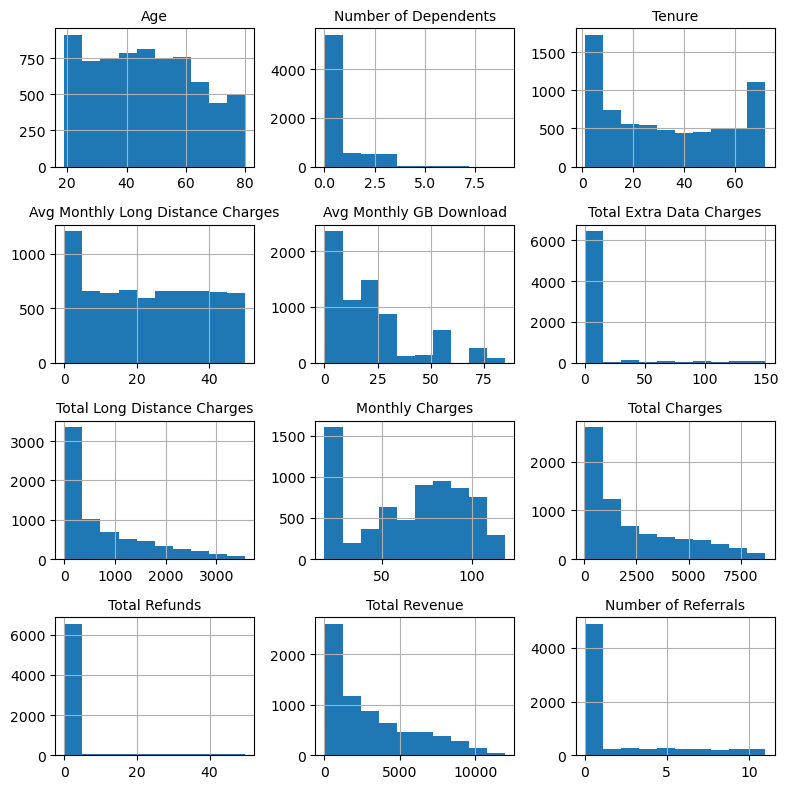

In [8]:
# Visualise the distributions of numeric factors
num_cols = df.select_dtypes(exclude='O').columns
plt.rcParams['axes.titlesize'] = 10
df[num_cols].hist(figsize=(8, 8))
plt.tight_layout()

Some of the numeric factors such as Number of Referrals and Number of Dependents are better suited as categorical factors. Since, Total Revenue = Total Charges(Monthly Charges * Tenure) + Total Long Distance Charges + Total Extra Data Charges - Total Refunds, I'll drop Total Revenue and Total Charges and keep the their components for a more granular understanding of the data.

In [9]:
df2 = df.copy().drop(['Total Revenue', 'Total Charges'], axis=1)

I'll categorise the values in Number of Referrals in 4 bins based on their relative churn frequencies.

In [10]:
pd.crosstab(df2['Number of Referrals'], df2.Churn)

Churn,No,Yes
Number of Referrals,,
0,2574,1245
1,579,507
2,208,26
3,222,32
4,217,18
5,240,21
6,212,8
7,242,6
8,210,2


In [11]:
df2['Number of Referrals'] = df2['Number of Referrals'].replace({0: '0', 1: '1'}) \
                                                       .apply(lambda x: '2 to 5' if x in [2, 3, 4, 5] else x) \
                                                       .apply(lambda x: '6' if x in [6, 7, 8, 9, 10, 11] else x)

I'll drop the Number of Dependents factor because there is not enough data for customers with 4 and more children and also because we can easily tell that customers with no children have a significantly higher churn rate than customers with 1 to 3 children, who all share a similar churn rate; i.e., this factor doesn't provide any more information already contained in the Dependents factor.

In [85]:
pd.crosstab(df2['Number of Dependents'], df2.Churn)

Churn,No,Yes
Number of Dependents,,
0,3649,1763
1,512,38
2,496,33
3,485,30
4,8,1
5,8,2
6,2,1
7,1,1
8,1,0


In [12]:
df2 = df2.drop('Number of Dependents', axis=1)

I'll bin the values of Total Refunds according to their relative frequencies.

In [13]:
refunds_binned = pd.cut(df2.query('`Total Refunds` != 0')['Total Refunds'], 5, include_lowest=True)
df2['Total Refunds'] = pd.concat((df2.query('`Total Refunds` == 0')['Total Refunds'], refunds_binned)).astype(str).sort_index()
df2['Total Refunds'].value_counts()

0.0                 6507
(10.766, 20.522]     114
(40.034, 49.79]      113
(20.522, 30.278]     111
(30.278, 40.034]      97
(0.96, 10.766]        90
Name: Total Refunds, dtype: int64

Most of the values of Total Extra Data Charges are 0, which will be a bin by itself, while the remaining values will be binned in equal intervals of 50.

In [14]:
tedc_binned = pd.cut(df2.query('`Total Extra Data Charges` != 0')['Total Extra Data Charges'], [10, 51, 100, 151], labels=[('10 to 50'), ('60 to 100'), ('110 to 150')], include_lowest=True, right=False)
df2['Total Extra Data Charges'] = pd.concat((df2.query('`Total Extra Data Charges` == 0')['Total Extra Data Charges'], tedc_binned)).astype(str).sort_index()
df2['Total Extra Data Charges'].value_counts()

0             6304
10 to 50       352
110 to 150     224
60 to 100      152
Name: Total Extra Data Charges, dtype: int64

In [15]:
from scipy.stats import ttest_ind
from scipy.stats import boxcox

ttest_results = {}
num_cols = df2.select_dtypes(exclude='O').columns
print('Independent T-test Results')
for col in num_cols:
    results = ttest_ind(df2.loc[df2['Churn'] == "Yes"][col], df2.loc[df2['Churn'] == "No"][col], equal_var=False)
    ttest_results[col] = {'t-statistic': round(results[0], 3), 'p-value': round(results[1], 3)}
pd.DataFrame(ttest_results).T

Independent T-test Results


,t-statistic,p-value
Age,9.395,0.000
Tenure,-34.972,0.000
Avg Monthly Long Distance Charges,0.668,0.504
Avg Monthly GB Download,4.344,0.000
Total Long Distance Charges,-22.187,0.000
Monthly Charges,18.341,0.000


All numeric factors except Avg Monthly Long Distance Charges have a statistically significant association with Churn.

When it comes to the categorical factors, all of them, excluding Gender and Phone Service, have a statistically significant association with Churn. The factors Multiple Lines, Total Refunds, Streaming Music, and Total Extra Data Charges have much weaker associations compared with the rest.

In [16]:
from scipy.stats import chi2_contingency

chi2_results = {}
cat_cols = df2.iloc[:, :-2].select_dtypes("object").columns
print('Chi-square Test of Independence Results')
for col in cat_cols:
    results = chi2_contingency(pd.crosstab(df2[col], df2.Churn))
    chi2_results[col] = {'chi2-statistic': round(results[0], 3), 'p-value': round(results[1], 3)}
pd.DataFrame(chi2_results).T.sort_values('chi2-statistic')

Chi-square Test of Independence Results


,chi2-statistic,p-value
Gender,0.475,0.490
Phone Service,0.874,0.350
Multiple Lines,11.272,0.004
Total Refunds,13.283,0.021
Streaming Music,14.095,0.000
Total Extra Data Charges,34.512,0.000
Referred a Friend,154.634,0.000
Married,157.503,0.000
Senior Citizen,158.441,0.000
Dependents,186.322,0.000


Narrowing down the factors.

In [17]:
# Significant factors identified by t- and chi-square tests
main_cols = num_cols.drop('Avg Monthly Long Distance Charges').append(cat_cols.drop(['Gender', 'Phone Service']))

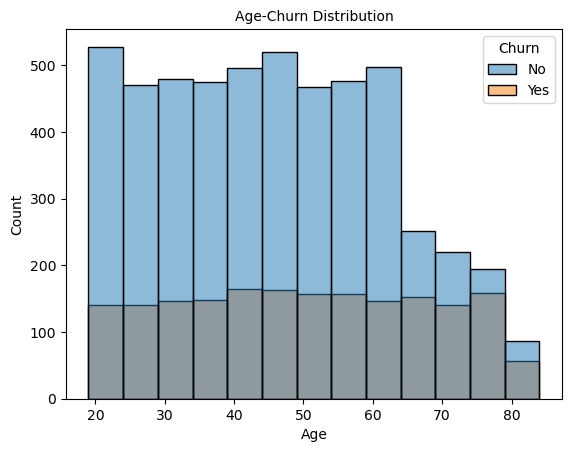

In [18]:
main_cols = main_cols.drop(['Multiple Lines', 'Total Refunds', 'Streaming Music', 'Total Extra Data Charges', # Drop categorical factors with much weaker relative associations
                            'Referred a Friend', # Drop Referred a Friend because Number of Referrals is more informative
                            'Avg Monthly GB Download', # Drop Avg Monthly GB Download because it has a much weaker relative association
                            'Age'] # Drop Age because there doesn't seem to be a significant difference in Churn before Age 65
                            )

sns.histplot(x=df2.Age, hue=df2.Churn, binwidth=5)
plt.title('Age-Churn Distribution');

Training a CatBoost model to further narrow down the factors.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df2[main_cols], df2['Churn'], stratify=df['Churn'], test_size=0.2, random_state=42)

In [21]:
cat_features = df2[main_cols].select_dtypes('O').columns.to_list()
train_pool = Pool(X_train, y_train, cat_features=cat_features)

In [22]:
param_grid = {'learning_rate': [0.01, 0.02], 
              'depth': [4, 5, 6],
              'l2_leaf_reg': [1, 3, 5]}
              
model = CatBoostClassifier(random_seed=42, verbose=False, early_stopping_rounds=100, iterations=2000, auto_class_weights='Balanced')
gs = model.grid_search(param_grid, train_pool, refit=False, stratified=True, search_by_train_test_split=False, cv=3)

Training on fold [0/3]

bestTest = 0.4397438667
bestIteration = 1136

Training on fold [1/3]

bestTest = 0.428442203
bestIteration = 1083

Training on fold [2/3]

bestTest = 0.4361381247
bestIteration = 956

0:	loss: 0.4350777	best: 0.4350777 (0)	total: 44.3s	remaining: 12m 33s
Training on fold [0/3]

bestTest = 0.4409493884
bestIteration = 526

Training on fold [1/3]

bestTest = 0.4274045182
bestIteration = 476

Training on fold [2/3]

bestTest = 0.4362070264
bestIteration = 520

1:	loss: 0.4357225	best: 0.4350777 (0)	total: 1m 7s	remaining: 8m 56s
Training on fold [0/3]

bestTest = 0.4414202263
bestIteration = 1233

Training on fold [1/3]

bestTest = 0.4282560911
bestIteration = 929

Training on fold [2/3]

bestTest = 0.4359430058
bestIteration = 1048

2:	loss: 0.4356609	best: 0.4350777 (0)	total: 1m 49s	remaining: 9m 8s
Training on fold [0/3]

bestTest = 0.441646168
bestIteration = 552

Training on fold [1/3]

bestTest = 0.4270523472
bestIteration = 555

Training on fold [2/3]

best

In [23]:
# Best params
gs['params']

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.01}

In [24]:
pd.DataFrame(gs['cv_results']).tail()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
1232,1232,0.435064,0.005658,0.393068,0.004900
1233,1233,0.435071,0.005667,0.393056,0.004919
1234,1234,0.435074,0.005670,0.393045,0.004938
1235,1235,0.435071,0.005666,0.393038,0.004948
1236,1236,0.435078,0.005675,0.393026,0.004967


In [25]:
final_model = CatBoostClassifier(random_seed=42, verbose=False, auto_class_weights='Balanced', **gs['params'], iterations=1137)
final_model.fit(train_pool)

The model does a decent job of correctly identifying 312/374 churn cases at the cost of 246 false positives.

Recall score: 83.4%


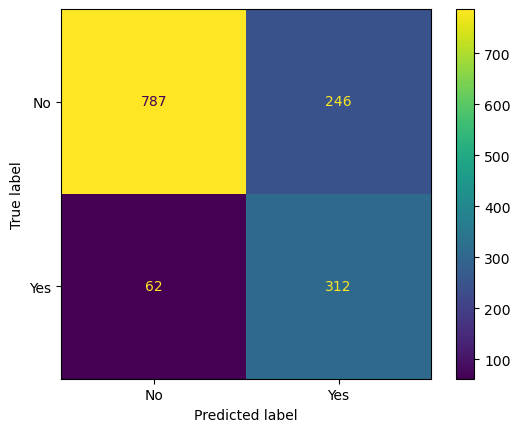

In [26]:
print(f'Recall score: {round(312/(312+62) * 100, 1)}%')
ConfusionMatrixDisplay.from_predictions(y_test, final_model.predict(X_test));

In [28]:
importances = pd.DataFrame(final_model.feature_importances_, index=final_model.feature_names_).sort_values(0, ascending=False)
importances

,0
Number of Referrals,32.667797
Contract,18.907757
Internet Service,10.137259
Tenure,9.999968
Monthly Charges,4.011162
Online Security,3.966641
Total Long Distance Charges,3.122826
Tech Support,3.083395
Payment Method,2.624717
Streaming TV,2.589282


# Analysing the top 8 factors

3 of the top 8 factors, Number of Referrals, Tenure, and Total Long Distance Charges are not a provided service or a fixed price set by the telco.

In [29]:
top8 = importances[:8].index
top8

Index(['Number of Referrals', 'Contract', 'Internet Service', 'Tenure',
       'Monthly Charges', 'Online Security', 'Total Long Distance Charges',
       'Tech Support'],
      dtype='object')

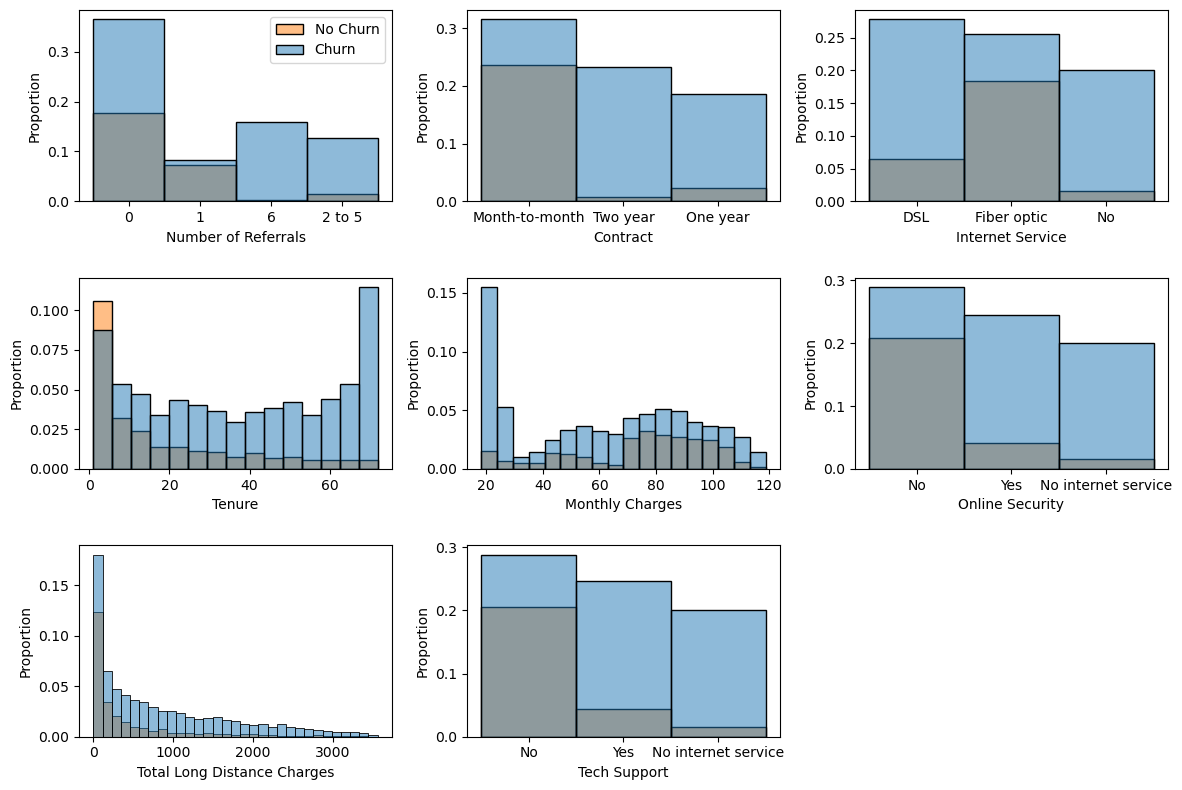

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
for factor, ax in zip(top8, axes.flatten()):
    sns.histplot(x=df2[factor], hue=df2.Churn, stat='proportion', ax=ax, legend=False)

axes[0, 0].legend(['No Churn', 'Churn'])
axes[2, 2].set_axis_off()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

1. Customers with more than 1 referral have a much lower churn rate than the rest probably because they think highly of the telco and are less likely to leave. Interestingly, the churn rate of customers with exactly 1 referral is much higher than that of customers with no referrals. However, the mean tenure length of customers with only 1 referral is not particularly low, which rules out the idea of customers leaving after redeeming some sort of referral deal. The telco could consider conducting a survey with customers who have a high number of referrals to better understand their strengths.

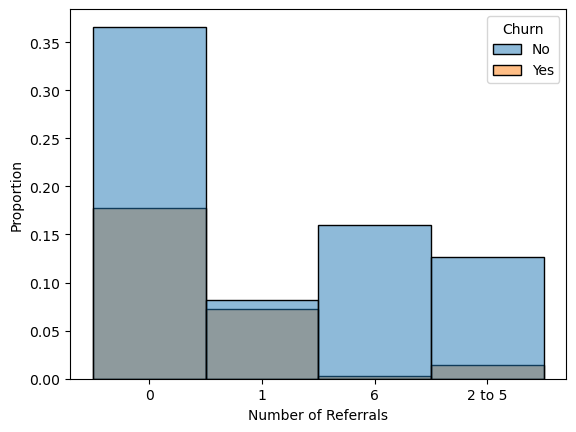

In [31]:
sns.histplot(x=df2['Number of Referrals'], hue=df2.Churn, stat='proportion');

In [32]:
df2.groupby('Number of Referrals').Tenure.mean()

Number of Referrals
0         24.240115
1         36.126151
2 to 5    44.786585
6         45.594051
Name: Tenure, dtype: float64

2. Customers with one- or two-year contracts are significantly less likely to leave and have much longer tenure lengths. Part of what contributes to the elevated churn rate for Month-to-month customers is because of Offer E, where customers join for the offer and leave once their contract is over. The telco should promote long-term over Month-to-month contracts and get existing Month-to-month customers to switch to long-term contracts as much as possible for greater customer retention.

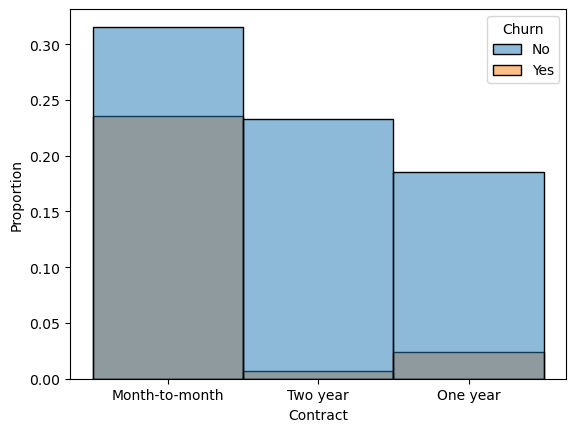

In [33]:
sns.histplot(x=df2['Contract'], hue=df2.Churn, stat='proportion');

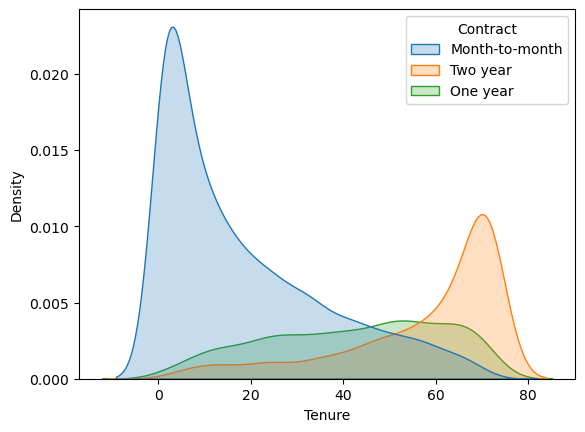

In [34]:
sns.kdeplot(x=df2['Tenure'], hue=df2['Contract'], fill=True);

In [35]:
pd.crosstab(df2['Offer'], df2['Contract'])

Contract,Month-to-month,One year,Two year
Offer,,,
None,2177,801,891
Offer A,21,96,403
Offer B,236,312,276
Offer C,232,132,51
Offer D,452,106,44
Offer E,757,25,20


3. Customers with the Fiber optic internet service have a significantly higher churn rate than those with DSL, suggesting that the Fiber optic service is bad and the telco should improve upon it. The telco should communicate with existing users of their fiber optic service with regard to its issues to minimise churn risks.

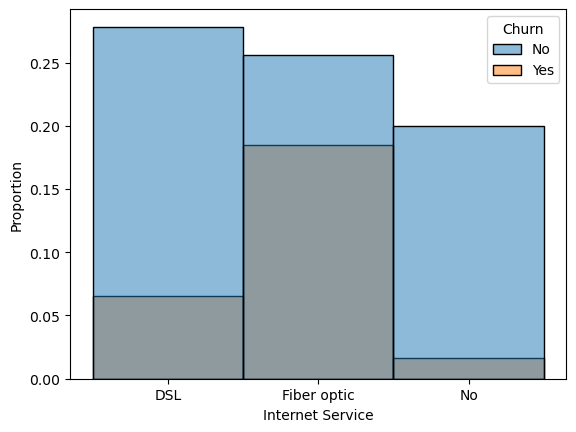

In [36]:
sns.histplot(x=df2['Internet Service'], hue=df2.Churn, stat='proportion');

4. Churn tends to decrease as tenure length increases. The tenure length between 1 to 5 months has an extremely high churn rate, which can be partly attributed to customers who joined for Offer E. The telco should re-evaluate its offers, particularly that of Offer E which not only has terrible retention, but also brings in the lowest revenue.

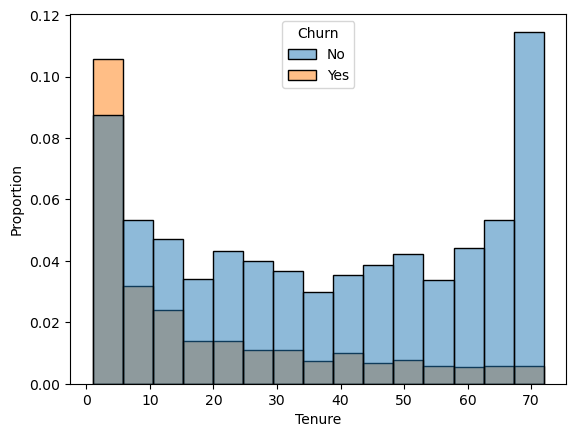

In [37]:
sns.histplot(x=df2['Tenure'], hue=df2.Churn, stat='proportion');

In [39]:
df2.groupby('Offer')[['Tenure', 'Monthly Charges']].agg(['mean', 'median'])

Tenure        Monthly Charges       
              mean median            mean median
Offer                                           
None     31.610752   29.0       64.400323  70.20
Offer A  70.000000   71.0       77.719519  85.30
Offer B  53.358010   54.0       70.829976  79.35
Offer C  30.761446   30.0       66.578313  74.75
Offer D  15.951827   16.0       58.168937  60.40
Offer E   3.680798    3.0       56.197506  55.65

5. The distribution of Churn: Yes across Monthly Charges is approximately the same as the distribution of Contract: Month-to-month across Monthly Charges, which suggests that between the monthly charge the customer pays and their type of contract, the latter is more predictive of their churn behaviour.

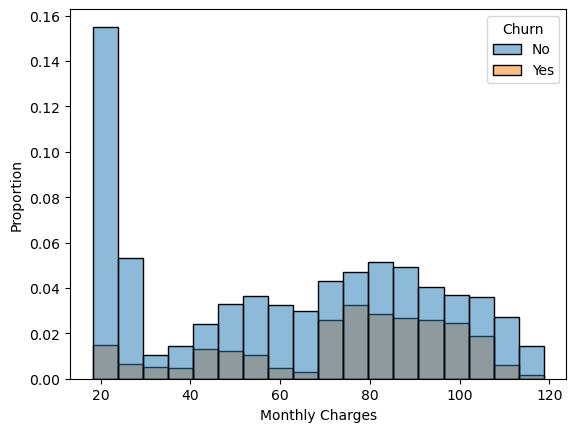

In [40]:
sns.histplot(x=df2['Monthly Charges'], hue=df2['Churn'], stat='proportion');

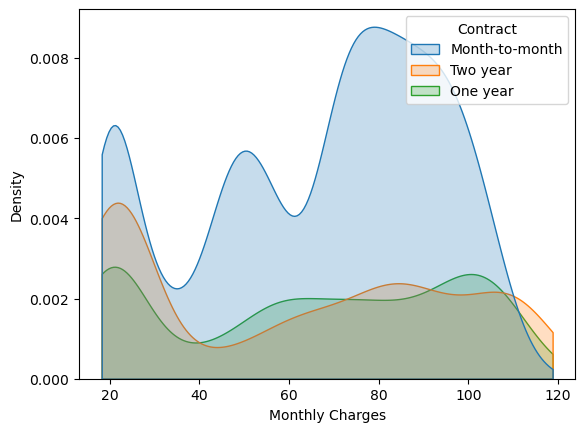

In [41]:
sns.kdeplot(x=df2['Monthly Charges'], hue=df2['Contract'], clip=([df2['Monthly Charges'].min(), df2['Monthly Charges'].max()]), fill=True);

6. Customers whose contracts do not include Online Security or Tech Support are much more likely to churn than those that do. The telco could consider upgrading customers to a package that includes Online Security and/or Tech Support as part of a deal or a free gift since after all, prices of these two types of contracts are similar.

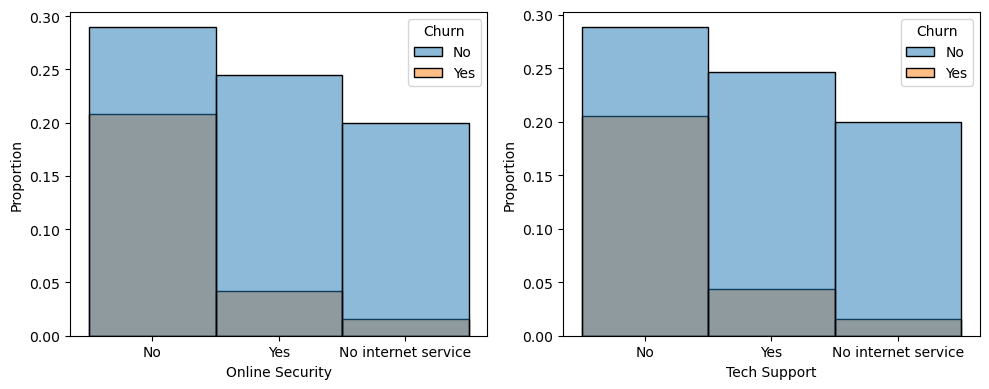

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(x=df2['Online Security'], hue=df2['Churn'], stat='proportion', ax=axes[0]);
sns.histplot(x=df2['Tech Support'], hue=df2['Churn'], stat='proportion', ax=axes[1]);
plt.tight_layout()

In [43]:
print(df2.groupby('Online Security')['Monthly Charges'].agg(['mean', 'median']))
print(df2.groupby('Tech Support')['Monthly Charges'].agg(['mean', 'median']))

                          mean  median
Online Security                       
No                   75.693737   79.30
No internet service  21.076283   20.15
Yes                  78.870496   79.85
                          mean  median
Tech Support                          
No                   74.584879  78.050
No internet service  21.076283  20.150
Yes                  80.718799  81.725


7. After factoring out customers who leave after 1 month, Total Long Distance Charges as a factor isn't particularly helpful in explaining churn rate with the exception that customers with Two year contracts who churn, pay about 300 more in Total Long Distance Charges that those who don't.

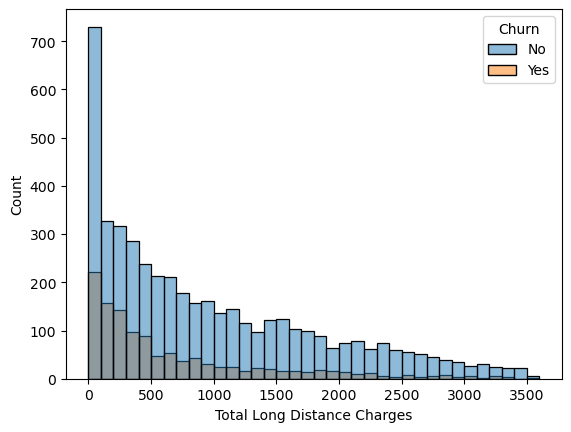

In [44]:
sns.histplot(x=df2.query('Tenure > 1')['Total Long Distance Charges'], hue=df2.query('Tenure >4')['Churn'], binwidth=100);

In [45]:
# T-test p-value: 0.06
# ttest_ind(df2.query('Tenure > 1 and Contract == "Two year" and Churn == "Yes"')['Total Long Distance Charges'], df2.query('Tenure > 1 and Contract == "Two year" and Churn == "No"')['Total Long Distance Charges'])
df2.query('Tenure > 1').groupby(['Contract', 'Churn'])['Total Long Distance Charges'].agg(['mean', 'median', 'count'])

mean    median  count
Contract       Churn                              
Month-to-month No      531.094028   293.275   1996
               Yes     428.270761   196.230   1275
One year       No     1000.764280   813.240   1299
               Yes    1093.888434   968.440    166
Two year       No     1282.832691  1139.840   1635
               Yes    1557.052708  1561.415     48

# Segmenting customers based on their risk of churn

Using the prediction probabilities from the CatBoost model earlier, I define low-risk as instances with probabilities < 34%, high-risk as > 66%, and mid-risk as the range in-between. Priority within each group can be derived by their Customer Value.

In [46]:
churn_probas = np.round(final_model.predict_proba(X_test)[:, 1], 2)
X_test['ChurnProba'] = churn_probas
X_test['Customer Value'] = df2['Tenure'] * df2['Monthly Charges'] + df2['Total Long Distance Charges']
low_risk = X_test.query('ChurnProba < .34').drop('ChurnProba', axis=1)
mid_risk = X_test.query('ChurnProba.between(.34, .66)').drop('ChurnProba', axis=1)
high_risk = X_test.query('ChurnProba > .66').drop('ChurnProba', axis=1)

# High-risk of churning customers
high_risk.head()

,Tenure,Total Long Distance Charges,Monthly Charges,Senior Citizen,Married,Dependents,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Unlimited Data,Contract,Paperless Billing,Payment Method,Number of Referrals,Offer,Customer Value
3564,15,352.95,74.20,Yes,No,No,Fiber optic,No,No,No,No,No,No,Yes,Month-to-month,Yes,Credit card (automatic),0,None,1465.95
405,2,35.46,79.20,Yes,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes,Month-to-month,No,Electronic check,1,Offer E,193.86
1319,4,51.44,88.85,Yes,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0,None,406.84
282,18,203.94,95.45,Yes,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,0,Offer D,1922.04
6097,11,336.27,84.80,No,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes,Month-to-month,No,Electronic check,0,None,1269.07
